In [1]:
import os
import re
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime as dt
from datetime import timedelta
from prometheus_pandas import query as pp

In [2]:
addr = 'vm.assol.ml'
username = os.environ['BASIC_AUTH_USER']
password = os.environ['BASIC_AUTH_PASS']

In [3]:
prometheus_url = 'https://{}:{}@{}/'.format(username, password, addr)

In [4]:
def get_servers(prometheus, job='node'):
    path = '/api/v1/targets'
    response = prometheus._do_query(path, None)
    active_targets = response.get('activeTargets', [])
    instances = []
    for target in active_targets:
        obj = target.get('discoveredLabels', None)
        if obj['job'] == 'node':
            instances.append(obj['__address__'].split(':', 1)[0])  
    return instances

In [5]:
prom = pp.Prometheus(prometheus_url)
instances = get_servers(prom, job='rpi')
print('Servers:', instances)

Servers: ['asuna', 'ichika', 'itsuki', 'miku', 'nino', 'rikka', 'yotsuba', 'zelda']


In [6]:
def rename_mapper(name):
    labels = re.split('{|}|,', name)
    result = labels[0]
    adds = []
    for label in labels[1:]:
        if len(label) > 0 and 'instance=' not in label and 'job=' not in label:
            adds.append(label)
    if len(adds) > 0:
        result += '{' + ','.join(adds) + '}'
    return result

In [7]:
def query(p, instance, job='node', name='', interval='10m'):
    promql = f'{{__name__=~"{name}.*", job="{job}", instance=~"{instance}.*"}}[{interval}]'
    print('PromQL:', promql)
    result = p.query(promql)
    result['instance'] = instance
    return result.rename(rename_mapper, axis='columns')

In [8]:
server = 'asuna'
job = 'rpi'
metric = 'rpi_cpu_temperature_celsius'

result = query(prom, server, job)
result.head()

PromQL: {__name__=~".*", job="rpi", instance=~"asuna.*"}[10m]


,"rpi_exporter_build_info{goversion=""go1.12.7""}","rpi_scrape_collector_success{collector=""cpu""}",scrape_duration_seconds,"rpi_scrape_collector_success{collector=""textfile""}",up,"rpi_scrape_collector_duration_seconds{collector=""cpu""}","rpi_scrape_collector_success{collector=""gpu""}","rpi_scrape_collector_duration_seconds{collector=""gpu""}",scrape_samples_scraped,rpi_cpu_temperature_celsius,"rpi_scrape_collector_duration_seconds{collector=""textfile""}",rpi_gpu_temperature_celsius,node_textfile_scrape_error,scrape_series_added,scrape_samples_post_metric_relabeling,instance
2021-04-22 02:09:00.144000053,1.0,1.0,0.016,1.0,1.0,0.002884,1.0,0.010972,10.0,44.790,0.000074,44.8,0.0,0.0,10.0,asuna
2021-04-22 02:09:15.144000053,1.0,1.0,0.018,1.0,1.0,0.000309,1.0,0.013054,10.0,44.790,0.000202,44.3,0.0,0.0,10.0,asuna
2021-04-22 02:09:30.144000053,1.0,1.0,0.018,1.0,1.0,0.000459,1.0,0.012956,10.0,45.277,0.000075,44.3,0.0,0.0,10.0,asuna
2021-04-22 02:09:45.144000053,1.0,1.0,0.018,1.0,1.0,0.000334,1.0,0.012351,10.0,44.790,0.000082,44.3,0.0,0.0,10.0,asuna
2021-04-22 02:10:00.144000053,1.0,1.0,0.019,1.0,1.0,0.000427,1.0,0.013443,10.0,44.303,0.000077,44.3,0.0,0.0,10.0,asuna


In [9]:
def draw(df, title=None):
    df.plot(legend=False, title=title)
    plt.show()

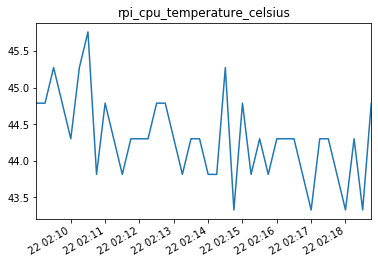

In [10]:
draw(result[metric], metric)

In [11]:
def query_range(p, instance, job='node', name='', start=None, end=dt.now(), step='1m'):
    promql = f'{{__name__=~"{name}.*", job="{job}", instance=~"{instance}.*"}}'
    print('PromQL:', promql)
    if start is None:
        start = dt.now() - timedelta(minutes=10)
    result = p.query_range(promql, start, end, step)
    result['instance'] = instance
    return result.rename(rename_mapper, axis='columns')

PromQL: {__name__=~"rpi_cpu_temperature_celsius.*", job="rpi", instance=~"asuna.*"}


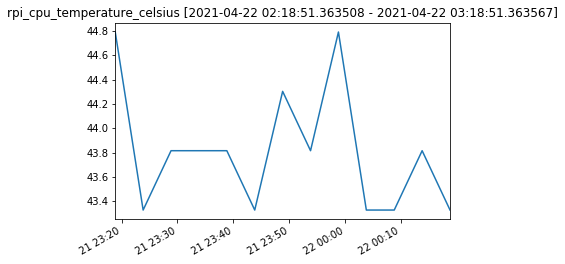

,rpi_cpu_temperature_celsius,instance
2021-04-21 23:18:51.362999916,44.790,asuna
2021-04-21 23:23:51.362999916,43.329,asuna
2021-04-21 23:28:51.362999916,43.816,asuna
2021-04-21 23:33:51.362999916,43.816,asuna
2021-04-21 23:38:51.362999916,43.816,asuna


In [12]:
start = dt.now() - timedelta(hours=3)
end = dt.now() - timedelta(hours=2)
step = '5m'

result = query_range(prom, server, job, metric, start, end, step)
draw(result, f'{metric} [{start} - {end}]')
result.head()

In [13]:
def collect_all_metrics(instances, job='node', metric='', step='30m', days=1):
    frames = []
    for day in range(days):
        start = dt.now() - timedelta(days=day+1)
        end = dt.now() - timedelta(days=day)
        print('Day:', start, end)
        for instance in instances:
            new_df = query_range(prom, instance, job, metric, start, end, step)
            frames.append(new_df)
    df = pd.concat(frames, sort=False)
    df.columns.names = ['date']
    return df

In [14]:
job = 'rpi'
metric = 'rpi_cpu_temperature_celsius'
step = '30m'

df = collect_all_metrics(instances, job, metric, step, 3)
df.head()

Day: 2021-04-21 05:18:51.733816 2021-04-22 05:18:51.733833
PromQL: {__name__=~"rpi_cpu_temperature_celsius.*", job="rpi", instance=~"asuna.*"}
PromQL: {__name__=~"rpi_cpu_temperature_celsius.*", job="rpi", instance=~"ichika.*"}
PromQL: {__name__=~"rpi_cpu_temperature_celsius.*", job="rpi", instance=~"itsuki.*"}
PromQL: {__name__=~"rpi_cpu_temperature_celsius.*", job="rpi", instance=~"miku.*"}
PromQL: {__name__=~"rpi_cpu_temperature_celsius.*", job="rpi", instance=~"nino.*"}
PromQL: {__name__=~"rpi_cpu_temperature_celsius.*", job="rpi", instance=~"rikka.*"}
PromQL: {__name__=~"rpi_cpu_temperature_celsius.*", job="rpi", instance=~"yotsuba.*"}
PromQL: {__name__=~"rpi_cpu_temperature_celsius.*", job="rpi", instance=~"zelda.*"}
Day: 2021-04-20 05:18:52.044965 2021-04-21 05:18:52.044975
PromQL: {__name__=~"rpi_cpu_temperature_celsius.*", job="rpi", instance=~"asuna.*"}
PromQL: {__name__=~"rpi_cpu_temperature_celsius.*", job="rpi", instance=~"ichika.*"}
PromQL: {__name__=~"rpi_cpu_temperature

date,rpi_cpu_temperature_celsius,instance
2021-04-21 02:18:51.733000040,44.790,asuna
2021-04-21 02:48:51.733000040,43.329,asuna
2021-04-21 03:18:51.733000040,44.303,asuna
2021-04-21 03:48:51.733000040,43.816,asuna
2021-04-21 04:18:51.733000040,43.816,asuna


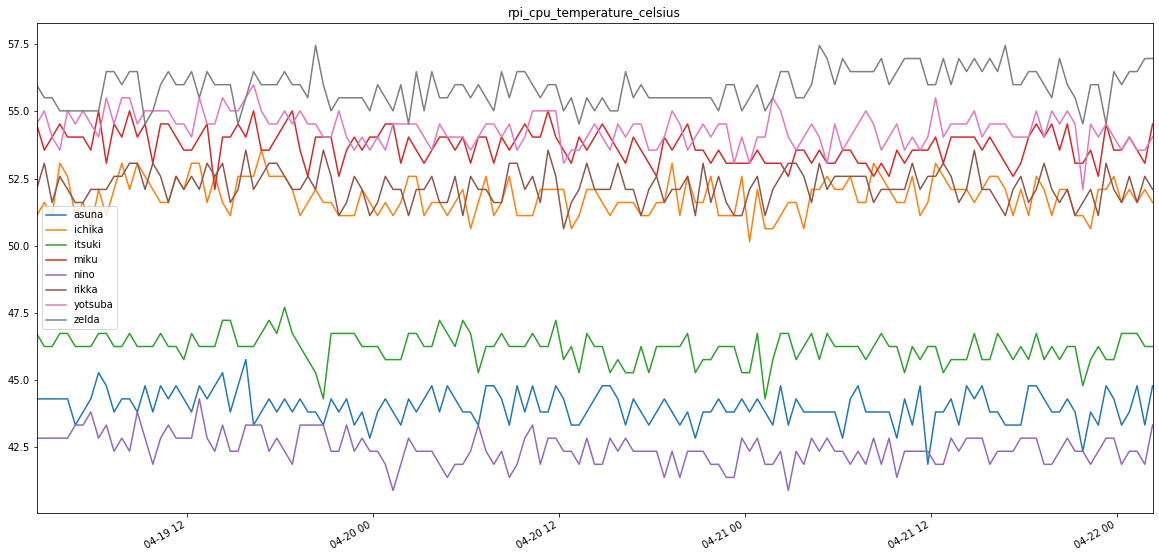

In [15]:
fig, ax = plt.subplots(figsize=(20,10))
groupby = df.groupby(['instance'])
groupby.plot(ax=ax)
ax.legend(list(groupby.groups.keys()));
plt.title(metric)
plt.show()

In [16]:
df = collect_all_metrics(instances, 'node', 'node', '10m', 7)
df

Day: 2021-04-21 05:18:53.334755 2021-04-22 05:18:53.334767
PromQL: {__name__=~"node.*", job="node", instance=~"asuna.*"}
PromQL: {__name__=~"node.*", job="node", instance=~"ichika.*"}
PromQL: {__name__=~"node.*", job="node", instance=~"itsuki.*"}
PromQL: {__name__=~"node.*", job="node", instance=~"miku.*"}
PromQL: {__name__=~"node.*", job="node", instance=~"nino.*"}
PromQL: {__name__=~"node.*", job="node", instance=~"rikka.*"}
PromQL: {__name__=~"node.*", job="node", instance=~"yotsuba.*"}
PromQL: {__name__=~"node.*", job="node", instance=~"zelda.*"}
Day: 2021-04-20 05:19:19.959513 2021-04-21 05:19:19.959524
PromQL: {__name__=~"node.*", job="node", instance=~"asuna.*"}
PromQL: {__name__=~"node.*", job="node", instance=~"ichika.*"}
PromQL: {__name__=~"node.*", job="node", instance=~"itsuki.*"}
PromQL: {__name__=~"node.*", job="node", instance=~"miku.*"}
PromQL: {__name__=~"node.*", job="node", instance=~"nino.*"}
PromQL: {__name__=~"node.*", job="node", instance=~"rikka.*"}
PromQL: {__n

date,"node_network_receive_bytes_total{device=""eth0""}","node_scrape_collector_duration_seconds{collector=""bcache""}","node_scrape_collector_duration_seconds{collector=""arp""}","node_network_receive_bytes_total{device=""lo""}","node_scrape_collector_duration_seconds{collector=""btrfs""}","node_scrape_collector_duration_seconds{collector=""conntrack""}","node_scrape_collector_duration_seconds{collector=""cpu""}","node_scrape_collector_duration_seconds{collector=""bonding""}","node_scrape_collector_duration_seconds{collector=""cpufreq""}","node_scrape_collector_duration_seconds{collector=""diskstats""}",...,"node_systemd_unit_state{name=""systemd-localed.service"",state=""deactivating"",type=""dbus""}","node_systemd_unit_state{name=""systemd-localed.service"",state=""activating"",type=""dbus""}","node_systemd_unit_state{name=""systemd-localed.service"",state=""failed"",type=""dbus""}","node_systemd_unit_state{name=""systemd-localed.service"",state=""active"",type=""dbus""}","node_systemd_unit_state{name=""systemd-localed.service"",state=""inactive"",type=""dbus""}","node_systemd_unit_state{name=""uwsgi-app@marusya_skill.service.service"",state=""activating"",type=""simple""}","node_systemd_unit_state{name=""uwsgi-app@marusya_skill.service.service"",state=""active"",type=""simple""}","node_systemd_unit_state{name=""uwsgi-app@marusya_skill.service.service"",state=""deactivating"",type=""simple""}","node_systemd_unit_state{name=""uwsgi-app@marusya_skill.service.service"",state=""inactive"",type=""simple""}","node_systemd_unit_state{name=""uwsgi-app@marusya_skill.service.service"",state=""failed"",type=""simple""}"
2021-04-21 02:10:00,1.987748e+09,0.000019,0.000191,1.360255e+10,0.000020,0.000120,0.001396,0.000043,0.008945,0.000868,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-21 02:20:00,2.014233e+09,0.000022,0.000295,1.361227e+10,0.000023,0.000123,0.001362,0.000045,0.004168,0.000922,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-21 02:30:00,2.040583e+09,0.000021,0.000199,1.362199e+10,0.000026,0.000165,0.002174,0.000044,0.005851,0.000863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-21 02:40:00,2.067058e+09,0.000024,0.000206,1.363172e+10,0.000046,0.000126,0.001507,0.000077,0.004864,0.002000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-21 02:50:00,2.093327e+09,0.000019,0.000238,1.364144e+10,0.000023,0.000124,0.001462,0.000050,0.003962,0.002419,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-16 01:40:00,4.186226e+09,0.000050,0.000325,1.660014e+09,0.000042,0.000312,0.003405,0.000098,0.012795,0.001989,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-16 01:50:00,4.196991e+09,0.000051,0.000307,1.663956e+09,0.000045,0.003920,0.008710,0.000101,0.014398,0.005981,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-16 02:00:00,4.207488e+09,0.000046,0.000300,1.667896e+09,0.000043,0.000685,0.003324,0.000098,0.007386,0.002067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-16 02:10:00,4.218066e+09,0.000047,0.000358,1.671841e+09,0.000047,0.000311,0.003598,0.000095,0.007715,0.002082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


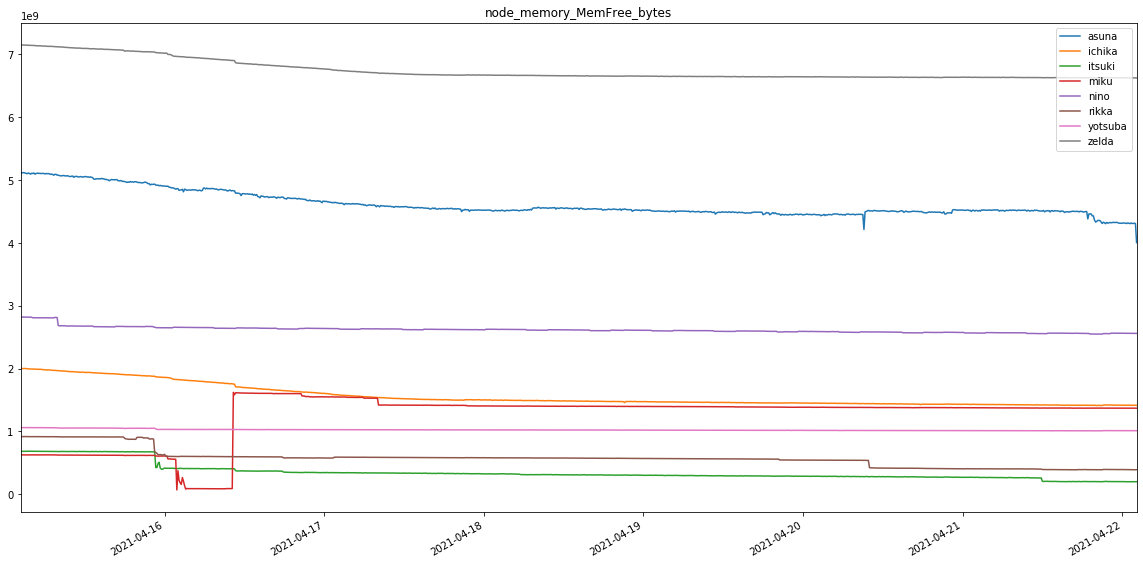

In [18]:
metric = 'node_memory_MemFree_bytes'

fig, ax = plt.subplots(figsize=(20,10))
groupby = df.groupby('instance')[metric]
groupby.plot(ax=ax)
ax.legend(list(groupby.groups.keys()));
plt.title(metric)
plt.show()

In [19]:
df.to_csv('node_data.csv')